In [83]:
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import networkx.algorithms.community as nxcomm

In [84]:
n = 100000
tau1 = 3 # 2-3
tau2 = 1.5 # 1-2
mu = 0.1

def create_benchmark_graph(n, tau1, tau2, mu, average_degree, min_community, seed):
    G = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=average_degree, \
            min_community=min_community, seed=seed
    )
    return G


In [161]:
configuration = {
    #'n':[1000,2000,4000,5000,6000,7000,8000,9000,10000,50000],
    'n':[10000,20000],
    'tau1': [3],
    'tau2': [1.5],
    #'mu': [0.1,0.2,0.3,0.4,0.5],
    'mu': [0.1],
    #'avg_degree': [4,6,8,10,12,14]
    'avg_degree': [6]
}

In [162]:

configurations_possible = []

def get_possible_configs(conf, index, current):

    if index == len(conf):
        configurations_possible.append(current.copy())
        print(current)
        return 

    here = list(conf.keys())[index]

    for value in conf[here]:
        current[here] = value
        get_possible_configs(conf, index + 1, current)


get_possible_configs(configuration, 0, {})


{'n': 10000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}


In [87]:
from collections import defaultdict
import community.community_louvain as community_louvain
import math

def get_communities(G):

    communities = {frozenset(G.nodes[v]["community"]) for v in G}
    # (com_nr, set community)
    lrf_dict = defaultdict()
    c = 1
    for y in communities:
        lrf_dict[c] = y
        c+= 1


    # (comm_nr, set communities)
    partion = community_louvain.best_partition(G)
    louvain_dict = defaultdict(set)
    for node, community in partion.items():
        louvain_dict[community].add(node) # (community_nr, nodes)

    return lrf_dict, louvain_dict



def get_percentage_intercetion(set_ids, mapping_ids):

    z = set()
    for id in set_ids:
        z = z.union(mapping_ids[id])
    return z


def is_small_community(G, community):
    res_limit_val = math.sqrt(2*G.number_of_edges())
    sub = G.subgraph(community)
    return sub.number_of_edges() < res_limit_val



def compare_communities_stats(G):

    lrf_dict, louvain_dict = get_communities(G)

    assigned_ones = defaultdict(set)# sets from the louvain that are assigned as most similar to the same set of the lrf

    for k, y in lrf_dict.items():
        
        higher = -1
        target_set = set() # set with the most common nodes
        overlapping_set_nr = set()

        for nr, com_set in louvain_dict.items():

            temp = com_set & y
            
            if len(temp) > 0:
                overlapping_set_nr.add(nr)
                assigned_ones[nr].add(k)

            
            if higher < len(temp):
                higher = len(temp)

        louvain_union = get_percentage_intercetion(overlapping_set_nr, louvain_dict)
        lrf_union = lrf_dict[k]
        percentage = len(louvain_union.intersection(lrf_union)) / max(len(louvain_union), len(lrf_union))
        #print("For lrf community with size {}, there were found in louvain {} communities overlapping".format(len(y), len(overlapping_set_nr)))
        print("For lrf community id {} (resol_lim : {}), they intersect with louvain communities ids {} => {}".format(k,\
        is_small_community(G, lrf_union) ,overlapping_set_nr, percentage))


    print("the other way around:")
    for k, y in assigned_ones.items(): 
        # k -> community id of louvain
        # y -> set of communities id of lrf
        # community id of louvain -> communties of lrf that overlap with the louvain
        louvain_union = louvain_dict[k]
        lrf_union = get_percentage_intercetion(y, lrf_dict)
        percentage = len(louvain_union.intersection(lrf_union)) / max(len(louvain_union), len(lrf_union))
        print("{} (louvain (resol_lim : {})) : {} (lrf) => {}" .format(k, is_small_community(G, louvain_union), y, percentage))

def compare_communities_number(G):
    partion = community_louvain.best_partition(G)
    l_c = max(partion.values())

    communities = {frozenset(G.nodes[v]["community"]) for v in G}
    lrf_c = len(communities)

    return l_c , lrf_c



In [88]:
def community_size_distribution(G):
    lrf_dict, louvain_dict = get_communities(G)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle('Internal degree of communities distribution')
    res_limit_val = math.sqrt(G.number_of_edges()/2)
    res_limit_val_2 = math.sqrt(2*G.number_of_edges())
    counter=collections.Counter([G.subgraph(x).number_of_edges() for x in lrf_dict.values()])
    counter2=collections.Counter([G.subgraph(x).number_of_edges() for x in louvain_dict.values()])
    ax1.hist(counter,bins=20)
    ax2.hist(counter2,bins=20)
    ax1.axvline(x=res_limit_val, color= 'r')
    ax2.axvline(x=res_limit_val, color= 'r')
    ax2.axvline(x=res_limit_val_2, color= 'r')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set(title='Real Communities', ylabel='Frequency',xlabel='Internal degree')
    ax2.set(title='Louvain Communities', ylabel='Frequency',xlabel='Internal degree')

In [165]:
def community_size_distribution_2(G):
    lrf_dict, louvain_dict = get_communities(G)
    counter=collections.Counter([G.subgraph(x).number_of_edges() for x in lrf_dict.values()])
    counter2=collections.Counter([G.subgraph(x).number_of_edges() for x in louvain_dict.values()])
    res_limit_val = math.sqrt(G.number_of_edges()/2)
    plt.figure(figsize=(6,6))
    plt.style.use('seaborn-whitegrid')
    plt.hist(counter,bins=20,alpha=0.7, label='x')
    plt.hist(counter2,bins=20,alpha=0.7, label='y')
    plt.axvline(x=res_limit_val, color= 'r')
    plt.legend(loc='upper right')
    plt.show()

In [89]:
def modularity_dif(G):
    lrf_dict, louvain_dict = get_communities(G)
    return nxcomm.modularity(G,louvain_dict.values()) - nxcomm.modularity(G,lrf_dict.values()) 
    

In [148]:
from networkx.utils import powerlaw_sequence
import powerlaw
import numpy as np
from scipy import stats

def powerlaw_dif(G):
    #pl_sequence = powerlaw_sequence(1000,exponent=2.5)
    #print(pl_sequence)
    lrf_dict, louvain_dict = get_communities(G)
    counter=[G.subgraph(x).number_of_nodes() for x in lrf_dict.values()]
    counter_2=[G.subgraph(x).number_of_nodes() for x in louvain_dict.values()]
    fitted_pl = powerlaw.Fit(counter,discrete=True)
    #fitted_pl.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
    #fitted_pl.plot_pdf( color= 'b')
    fitted_pl_2 = powerlaw.Fit(counter_2)
    #print(fitted_pl.alpha,fitted_pl_2.alpha)
    print(stats.kstest(counter,counter_2))

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle('Internal degree of communities distribution')
    res_limit_val = math.sqrt(G.number_of_edges()/2)
    #res_limit_val_2 = math.sqrt(2*G.number_of_edges())
    counter=collections.Counter([G.subgraph(x).number_of_edges() for x in lrf_dict.values()])
    counter2=collections.Counter([G.subgraph(x).number_of_edges() for x in louvain_dict.values()])
    ax1.hist(counter,bins=20)
    ax2.hist(counter2,bins=20)
    ax1.axvline(x=res_limit_val, color= 'r')
    ax2.axvline(x=res_limit_val, color= 'r')
    #ax2.axvline(x=res_limit_val_2, color= 'r')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set(title='Real Communities', ylabel='Frequency',xlabel='Internal degree')
    ax2.set(title='Louvain Communities', ylabel='Frequency',xlabel='Internal degree')

In [99]:
def run_experiment(configurations_possible, experiment_call_back):

    values = []
    for configuration in configurations_possible:
        print(configuration)
        G = create_benchmark_graph(configuration['n'], configuration['tau1'], \
            configuration['tau2'], configuration['mu'], \
            average_degree=configuration['avg_degree'], min_community=30, seed=10)
        values.append(experiment_call_back(G))
        #print(values)
    
    #print(values)
    return values

In [ ]:
run_experiment(configurations_possible, powerlaw_dif)

In [ ]:
run_experiment(configurations_possible, modularity_dif)

In [27]:
#run_experiment(configurations_possible, compare_communities_number)

In [28]:
#run_experiment(configurations_possible, compare_communities_stats)

In [ ]:
run_experiment(configurations_possible, community_size_distribution)


{'n': 10000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}


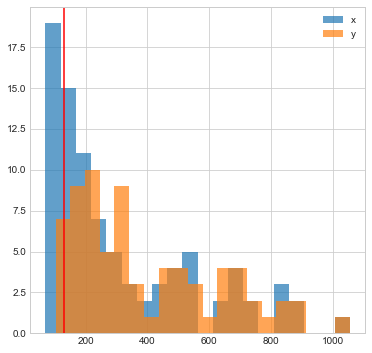

{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 6}


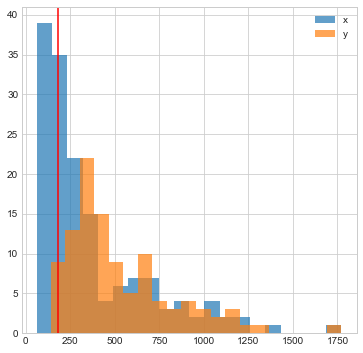

[None, None]

In [166]:
run_experiment(configurations_possible, community_size_distribution_2)